In [1]:
%matplotlib inline
from IPython.display import clear_output

import gc
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras import initializers
import sys
sys.path.append('/home/art/Programming/artlibs')
from artiom_convenience_functions import * 
from videorecorder import save_to_video, execute_at_exit



In [2]:
def s(img):
    plt.imshow(
    img.reshape(
    N_DIM, N_DIM), cmap='gray')

In [3]:
N_DIM = 64

faces = np.concatenate([np.fromfile(f"girls_img_{N_DIM}x{N_DIM}.bin", dtype="uint8").reshape(-1, N_DIM, N_DIM) / 255,

                        np.fromfile(f"boys_img_{N_DIM}x{N_DIM}.bin", dtype="uint8").reshape(-1, N_DIM, N_DIM) / 255])

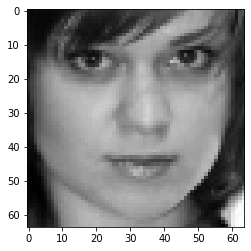

In [4]:
s(faces[2])

# Face generator


In [5]:
inputs = keras.Input(shape=(100))
x = Dense(100, activation='sigmoid', kernel_regularizer='l2')(inputs)
#x = Dropout(0.2)(x)
#x = Dense(1000, activation='sigmoid')(x)

x = Dense(4*(N_DIM + 1)** 2, activation='sigmoid', kernel_regularizer='l2')(x)
x = Reshape((2*N_DIM + 2, 2*N_DIM + 2, 1))(x)

x = Conv2D(300, (3, 3),)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(1, (1, 1), activation="sigmoid")(x)
print(x.shape)

print(x.shape)
x = Reshape((N_DIM, N_DIM))(x)
face_gen = keras.Model(inputs=inputs, outputs=x, name="face_generator")

face_gen.compile(

    optimizer=keras.optimizers.RMSprop(0.001),
    metrics=["accuracy"],
)

(None, 64, 64, 1)
(None, 64, 64, 1)



# policeman 

In [6]:
shape=(N_DIM, N_DIM)

In [7]:
inputs = keras.Input(shape=(N_DIM, N_DIM, 1))

x = Conv2D(160, (3, 3))(inputs)
x = MaxPool2D((2, 2))(x)

x = Conv2D(308, (5, 5))(x)
x = MaxPool2D((3, 3))(x)
#x = Conv2D(30, (4, 4))(x)
#x = MaxPool2D((4, 4))(x)


x = Flatten()(x)
x = Dense(1300, activation='sigmoid', kernel_regularizer='l2')(x)


outputs = Dense(1, activation='sigmoid')(x)
policeman = keras.Model(inputs=inputs, outputs=outputs, name="policeman")

In [8]:

policeman.compile(
    loss=keras.losses.BinaryCrossentropy(),

    optimizer=keras.optimizers.Adadelta(0.001),
    metrics=["accuracy"],
)

# Среда

In [9]:
policeman.trainable = False
inputs = keras.Input(shape=(100))
x = face_gen(inputs)
outputs = policeman(x) 
env_model = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

In [10]:

env_model.compile( loss="MSE"#"binary_crossentropy" 
)

In [11]:
env_model.summary()

Model: "face_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 face_generator (Functional)  (None, 64, 64)           1720301   
                                                                 
 policeman (Functional)      (None, 1)                 33668909  
                                                                 
Total params: 35,389,210
Trainable params: 1,720,301
Non-trainable params: 33,668,909
_________________________________________________________________


1/1 [==============================] - 57s 57s/step


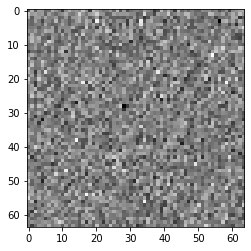

In [12]:
s(
    face_gen.predict(
        np.random.random(size=100).astype("float32").reshape(1, 100)
    ).reshape(N_DIM, N_DIM))

# Учим полицейского

In [13]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

In [14]:
faces_drawn_from_seeds = face_gen.predict(seeds)

10/10 [==============================] - 2s 35ms/step


In [15]:

indices = np.random.randint(0, len(faces), size=N)
real_faces = faces[indices]

In [16]:
X = np.concatenate([faces_drawn_from_seeds, real_faces])
X.shape

(628, 64, 64)

In [17]:
Y = np.zeros(
N * 2)

Y[N:] = 1

In [18]:
X[1]

array([[0.4999547 , 0.50056207, 0.49987796, ..., 0.50055325, 0.50038081,
        0.50060612],
       [0.50075638, 0.50043941, 0.50045806, ..., 0.50030375, 0.50078177,
        0.50037563],
       [0.50065017, 0.49992692, 0.50042498, ..., 0.50051552, 0.4994202 ,
        0.49998724],
       ...,
       [0.50022537, 0.50004023, 0.4999944 , ..., 0.50020564, 0.49996769,
        0.49973378],
       [0.5002991 , 0.50030369, 0.50024676, ..., 0.50019664, 0.50006366,
        0.50068694],
       [0.50019753, 0.49960619, 0.50027388, ..., 0.50034255, 0.50026828,
        0.50011921]])

0.0


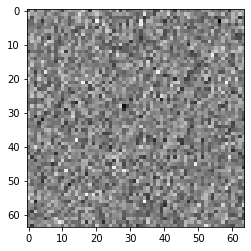

In [19]:
x, y = X[ind:=np.random.randint(0, len(X))],   Y[ind]
print(y)
s(x)

In [20]:
policeman.fit(X, Y, epochs=1, shuffle=1)
policeman.evaluate(X, Y)

20/20 [==============================] - 0s 8ms/step - loss: 25.3921 - accuracy: 0.5000


[25.39213752746582, 0.5]

# Теперь запускаем срелу

In [21]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

ones = np.ones(len(seeds), dtype="float32").reshape(-1, 1)


In [22]:
ones.shape

(314, 1)

In [23]:

seeds[0]

array([0.672602  , 0.8511656 , 0.57773805, 0.80848294, 0.582508  ,
       0.6787021 , 0.38667366, 0.27780604, 0.6688626 , 0.04634222,
       0.66604733, 0.7899299 , 0.11316022, 0.7012915 , 0.9810863 ,
       0.78394353, 0.4859033 , 0.20078714, 0.21337818, 0.29446784,
       0.5419946 , 0.3452963 , 0.7210823 , 0.14298868, 0.28603587,
       0.12273735, 0.28109464, 0.62947404, 0.64903915, 0.6740574 ,
       0.2755124 , 0.67233044, 0.97112215, 0.21926343, 0.3515918 ,
       0.88469714, 0.9387596 , 0.88035053, 0.31967133, 0.8705363 ,
       0.8626109 , 0.5454918 , 0.79560393, 0.7313583 , 0.91444117,
       0.43896502, 0.9286947 , 0.26650593, 0.7915714 , 0.716383  ,
       0.27787906, 0.3784121 , 0.26605085, 0.15122686, 0.75889593,
       0.6291776 , 0.04558965, 0.8181185 , 0.42065933, 0.70400643,
       0.6044455 , 0.73825514, 0.64615273, 0.06107252, 0.85845673,
       0.868719  , 0.6742233 , 0.53141725, 0.6097352 , 0.04471319,
       0.9846096 , 0.89701897, 0.6758144 , 0.27034447, 0.88367

In [24]:
env_model.fit(seeds, ones, shuffle=1, epochs=1)

10/10 [==============================] - 2s 116ms/step - loss: 26.4424


# В цикле

In [25]:
faces_drawn_from_seeds[0]

array([[0.49981958, 0.50072044, 0.49995422, ..., 0.50041294, 0.5004067 ,
        0.5005895 ],
       [0.5008483 , 0.50052327, 0.50050926, ..., 0.5002814 , 0.50075656,
        0.50038904],
       [0.5007004 , 0.4997673 , 0.50053966, ..., 0.500432  , 0.49941507,
        0.50004184],
       ...,
       [0.5002748 , 0.4999982 , 0.5001145 , ..., 0.50035435, 0.49985793,
        0.49966097],
       [0.5002096 , 0.5004142 , 0.50022143, ..., 0.50013655, 0.50011015,
        0.5007857 ],
       [0.50011533, 0.49961942, 0.5003051 , ..., 0.50029135, 0.50015646,
        0.5001244 ]], dtype=float32)

In [26]:
from importlib import reload

from videorecorder import get_new_cv2_imshow
from videorecorder import save_to_video, execute_at_exit

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )

In [27]:
2

2

In [29]:

cv2.destroyAllWindows()
from importlib import reload

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
#from videorecorder import save_to_video, execute_at_exit
from artiom_convenience_functions import *

from videorecorder import get_new_cv2_imshow
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )




key = None
policeman_epochs = 3
env_epochs = 3
while key not in (27,):
    N = 200
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)
    faces_drawn_from_seeds = face_gen.predict(seeds, verbose=0)

    
    
    best_ind = np.argmax(policeman.predict(faces_drawn_from_seeds, verbose=0).reshape(-1))
    illustration_img = uint8_normalized(cv2.cvtColor(
        
        fit_img_center(faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500, height=500,
                               interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB))
    my_imshow("result", illustration_img)
    #send_to_artmonitor(illustration_img, secret="artgan")
#     save_to_video((faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
#                                interpolation=cv2.INTER_NEAREST))
    key = cv2.waitKey(1)

    indices = np.random.randint(0, len(faces), size=N)
    real_faces = faces[indices]
    X = np.concatenate([faces_drawn_from_seeds, real_faces])
    Y = np.zeros(
    N * 2)

    Y[N:] = 1

    
    

    policeman.fit(X, Y, epochs=int(policeman_epochs), shuffle=1, verbose=0)
    caught = policeman.evaluate(X, Y, verbose=0)[1]
    print(caught, policeman_epochs, env_epochs)






    N = 200
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

    ones = np.ones(len(seeds)).reshape(-1, 1)
    
    if caught > 0.9:
          env_epochs = policeman_epochs * 5
    elif caught < 0.6:
        
        policeman_epochs = env_epochs * 5
        
        
    if env_epochs > 10 and policeman_epochs > 10:
        env_epochs /= 2
        policeman_epochs /= 2
    env_model.fit(seeds, ones, shuffle=1, epochs=int(env_epochs), verbose=0)
    
execute_at_exit()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


0.5575000047683716 3 3
0.5 15 3
0.5 15 3
0.6324999928474426 15 3
0.5 15 3
0.5699999928474426 15 3
0.5 15 3
0.5625 15 3
0.4449999928474426 15 3
0.0949999988079071 15 3
0.17499999701976776 15 3
0.02250000089406967 15 3
0.26249998807907104 15 3
0.5024999976158142 15 3
0.48750001192092896 15 3
0.5 15 3
1.0 15 3
0.512499988079071 7.5 37.5
1.0 93.75 18.75
0.6600000262260437 46.875 234.375
0.7524999976158142 23.4375 117.1875
0.7900000214576721 11.71875 58.59375
0.8025000095367432 5.859375 29.296875
0.8199999928474426 5.859375 29.296875
0.8575000166893005 5.859375 29.296875
0.8600000143051147 5.859375 29.296875
0.8774999976158142 5.859375 29.296875
0.8650000095367432 5.859375 29.296875
0.9075000286102295 5.859375 29.296875
0.8849999904632568 5.859375 29.296875
0.9024999737739563 5.859375 29.296875
0.9275000095367432 5.859375 29.296875
0.9424999952316284 5.859375 29.296875
0.9325000047683716 5.859375 29.296875
0.9424999952316284 5.859375 29.296875
0.9524999856948853 5.859375 29.296875
0.9524999

In [ ]:
execute_at_exit()

In [ ]:
cv2.cvtColor(resize(faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
                               interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB)

In [ ]:
caught

In [ ]:
policeman.evaluate(X, Y, verbose=0)